In [1]:
import sys
sys.path.append('/workspace/Documents')
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import pydicom
import cv2
import nibabel as nb

from skimage.draw import polygon
from scipy.spatial import ConvexHull
from scipy import ndimage
from skimage.draw import polygon2mask
from skimage.draw import polygon2mask
from scipy.spatial import ConvexHull
from scipy.interpolate import interp1d
from scipy.interpolate import splev, splprep

import PSF_generation.python.functions as ff

# Read the speadsheet for patient list

In [3]:
sheet = '/mnt/BPM_NAS/cleaned_labels/20240406_blur/all/Blur.csv'
sheet = pd.read_csv(sheet)
# only keep the one without blur
sheet = sheet[(sheet['Blur']==0) & (sheet['Exclude'] == 0)]
print(sheet.shape)

(898, 10)


# Pick one case

shape of the image data: (2850, 2394)
Pixel size: [0.1, 0.1]


Text(0.5, 1.0, 'Original Image')

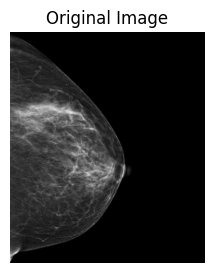

In [4]:
index = 0
patient = sheet.iloc[index]
patient_image_name = patient['Image']
patient_file = os.path.join('/mnt/BPM_NAS', patient['Folder'], 'data_lut', patient_image_name)
# read this dicom image using pydicom

# Read the DICOM image
dicom_image = pydicom.dcmread(patient_file)

# Access the image data
img = dicom_image.pixel_array
print('shape of the image data:', img.shape)

pixel_spacing = dicom_image.ImagerPixelSpacing
assert pixel_spacing[0] == pixel_spacing[1]
print('Pixel size:', pixel_spacing)

# Display the image
plt.figure(figsize = (3,3))
plt.subplot(111); plt.imshow(img, 'gray'); plt.axis('off'); plt.title('Original Image')



Total Length: [781.38896652]


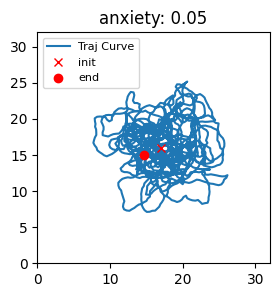

In [5]:
# set some simulation parameters
PSFsize = [32,32]
anxiety = 0.05 # what's this?
numT = 2000# the number of steps the motion trajectory should be sampled
limited_displacement = 1 / pixel_spacing[0] # the maximum displacement of the motion trajectory
MaxTotalLength = np.random.uniform(20,100) / pixel_spacing[0] # the maximum length of the motion trajectory

exposure_time = [1]

# noise paramters
sigma_gauss = 0.05

# create motion trajectory
TrajCurve = ff.create_motion_trajectory(PSFsize, anxiety, numT, MaxTotalLength,limited_displacement, plot_traj=True)

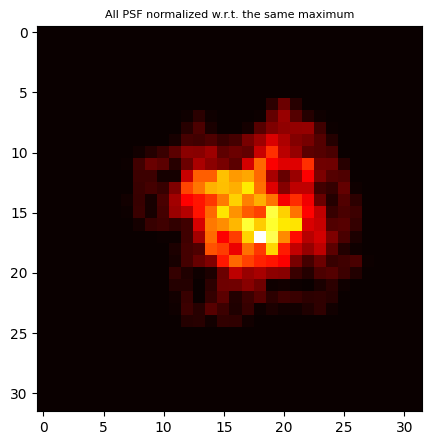

In [6]:
# create PSF for each exposure time
PSFS = ff.create_PSF(TrajCurve, exposure_time, PSFsize, plot_PSF=True)

Text(0.5, 1.0, 'ROI')

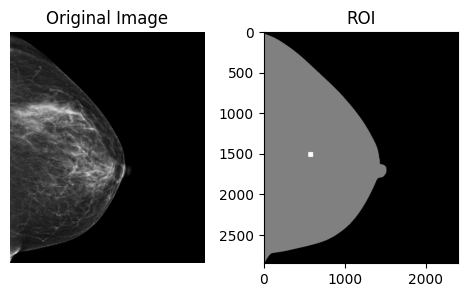

In [7]:
# Display the image
plt.figure(figsize = (6,3))
plt.subplot(121); plt.imshow(img, 'gray'); plt.axis('off'); plt.title('Original Image')

img_binary = np.zeros_like(img)
img_binary[img > 0] = 1
center_of_mass = ndimage.measurements.center_of_mass(img > 0)
center_of_mass = [int(center_of_mass[0]), int(center_of_mass[1])]
img_binary[center_of_mass[0]-30: center_of_mass[0]+30, center_of_mass[1]-30: center_of_mass[1]+30] = 2
plt.subplot(122); plt.imshow(img_binary, 'gray'); plt.title('ROI')


center of mass: [1511, 573]
570 950


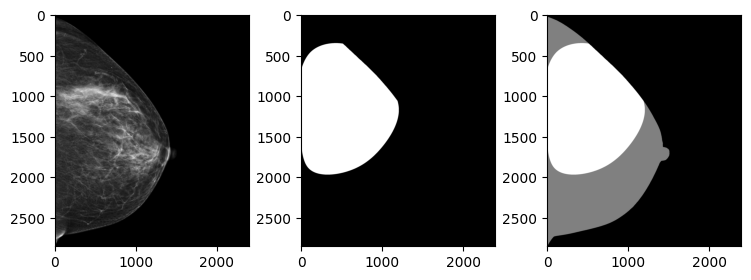

In [30]:
# create a random ROI
print('center of mass:', center_of_mass)
print(img.shape[0]//5, img.shape[0]//3)
ROI = ff.create_random_ROI(img, radius_range = [img.shape[0]//5 img.shape[0]//3],center_of_mass = center_of_mass, plot_ROI=True)



[0.00000000e+00 3.13948403e-06 6.27896807e-06 ... 9.99995989e-01
 9.99996861e-01 1.00000000e+00]


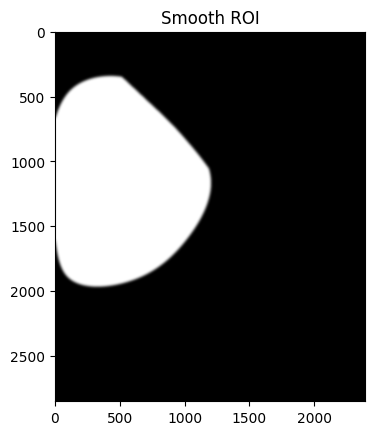

In [31]:
# for ROI how to gaussian smooth it to have a smooth boundary between 1 and 0. plot the result
ROI_copy = np.copy(ROI)
smooth_ROI = cv2.GaussianBlur(ROI_copy.astype(float), (51,51), 10)
print(np.unique(smooth_ROI))
plt.imshow(smooth_ROI, cmap='gray')
plt.title('Smooth ROI')
plt.show()

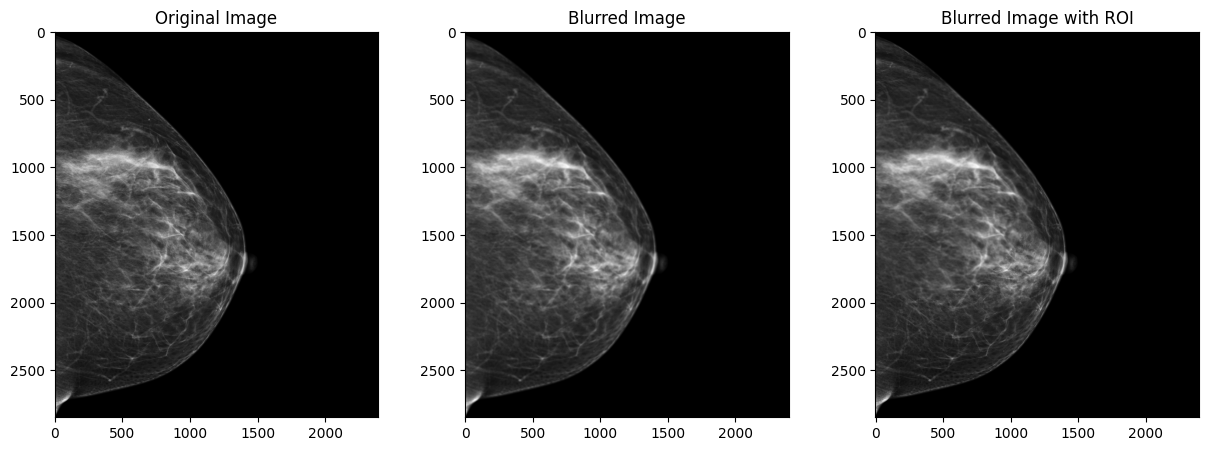

In [33]:
# create final blurred image
final_img = ff.create_motion_blur_img(img, PSFS, add_noise=False, sigma_gauss=sigma_gauss)[:,:,0]
# scale the final image so that keep the intensity range same
final_img = (final_img - np.min(final_img)) / (np.max(final_img) - np.min(final_img)) * (np.max(img) - np.min(img)) + np.min(img)

# some chances that only part of the image is blurred
if np.random.rand() > 0:
    final_img_roi_direct = np.copy(img)
    final_img_roi_direct[ROI] = final_img[ROI]

    # use smooth ROI
    final_img_roi_smooth = final_img * smooth_ROI + img * (1 - smooth_ROI)

    # final_img_roi_direct = np.round(final_img_roi_direct).astype(np.uint8)
    # final_img_roi_smooth = np.round(final_img_roi_smooth).astype(np.uint8)
else:
    print('no ROI')
    final_img_roi = final_img

# make sure the background is always 0
final_img[img<=0] = img[img<=0]; final_img = np.round(final_img)
final_img_roi_direct[img<=0] = img[img<=0]; final_img_roi_direct = np.round(final_img_roi_direct)
final_img_roi_smooth[img<=0] = img[img<=0]; final_img_roi_smooth = np.round(final_img_roi_smooth)

plt.figure(figsize = (15,5))
plt.subplot(131); plt.imshow(img, 'gray')
plt.title('Original Image')
plt.subplot(132); plt.imshow(final_img, 'gray')
plt.title('Blurred Image')
plt.subplot(133); plt.imshow(final_img_roi_direct, 'gray')
plt.title('Blurred Image with ROI')

nb.save(nb.Nifti1Image(img, np.eye(4)), '/mnt/BPM_NAS/cleaned_labels/20240406_blur/all/Original.nii.gz')
nb.save(nb.Nifti1Image(ROI.astype(float), np.eye(4)), '/mnt/BPM_NAS/cleaned_labels/20240406_blur/all/ROI.nii.gz')
nb.save(nb.Nifti1Image(smooth_ROI, np.eye(4)), '/mnt/BPM_NAS/cleaned_labels/20240406_blur/all/smooth_ROI.nii.gz')
nb.save(nb.Nifti1Image(final_img, np.eye(4)), '/mnt/BPM_NAS/cleaned_labels/20240406_blur/all/Blurred_all.nii.gz')
nb.save(nb.Nifti1Image(final_img_roi_direct, np.eye(4)), '/mnt/BPM_NAS/cleaned_labels/20240406_blur/all/Blurred_direct.nii.gz')
nb.save(nb.Nifti1Image(final_img_roi_smooth, np.eye(4)), '/mnt/BPM_NAS/cleaned_labels/20240406_blur/all/Blurred_smooth.nii.gz')

In [17]:
np.unique(ROI_save.astype(int))

array([0, 1])